In [1]:
# MA Cross Backtesting on 1H BTC futures on lower granularity
# - Taker fee               is 0.05%
# - Initial capital         is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe               is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/crypto-futures/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)
df_

,Open,High,Low,Close,Volume
date,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7177.00,7182.44,246.092
2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,70.909
2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,99.420
2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,69.330
2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,97.368
...,...,...,...,...,...
2023-12-31 23:55:00,42250.60,42269.90,42250.50,42258.60,79.986
2023-12-31 23:56:00,42258.70,42274.40,42250.50,42274.40,53.364
2023-12-31 23:57:00,42274.30,42315.60,42274.30,42310.90,69.259


<Axes: xlabel='date'>

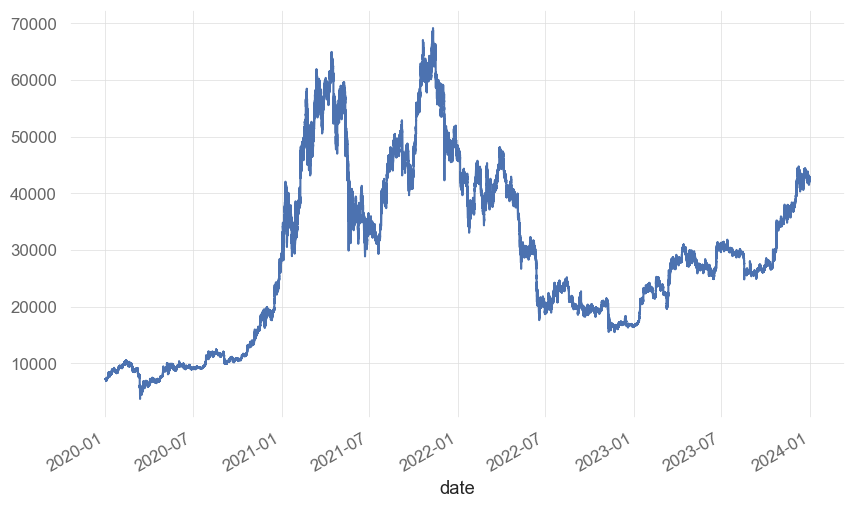

In [4]:
df_['Close'].plot()

In [5]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
date,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7170.15,7171.55,2449.049
2020-01-01 01:00:00,7171.43,7225.00,7171.10,7210.24,3865.038
2020-01-01 02:00:00,7210.38,7239.30,7206.46,7237.99,3228.365
2020-01-01 03:00:00,7237.41,7239.74,7215.00,7221.65,2513.307
2020-01-01 04:00:00,7221.80,7225.41,7211.22,7213.86,1176.666
...,...,...,...,...,...
2023-12-31 19:00:00,42701.70,42741.90,42624.70,42659.90,3944.096
2023-12-31 20:00:00,42659.90,42724.50,42543.30,42599.10,4730.936
2023-12-31 21:00:00,42599.20,42717.00,42558.20,42558.90,3794.010


In [6]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [7]:
df['Signal'].value_counts()

Signal
 0    34115
 1      427
-1      426
Name: count, dtype: int64

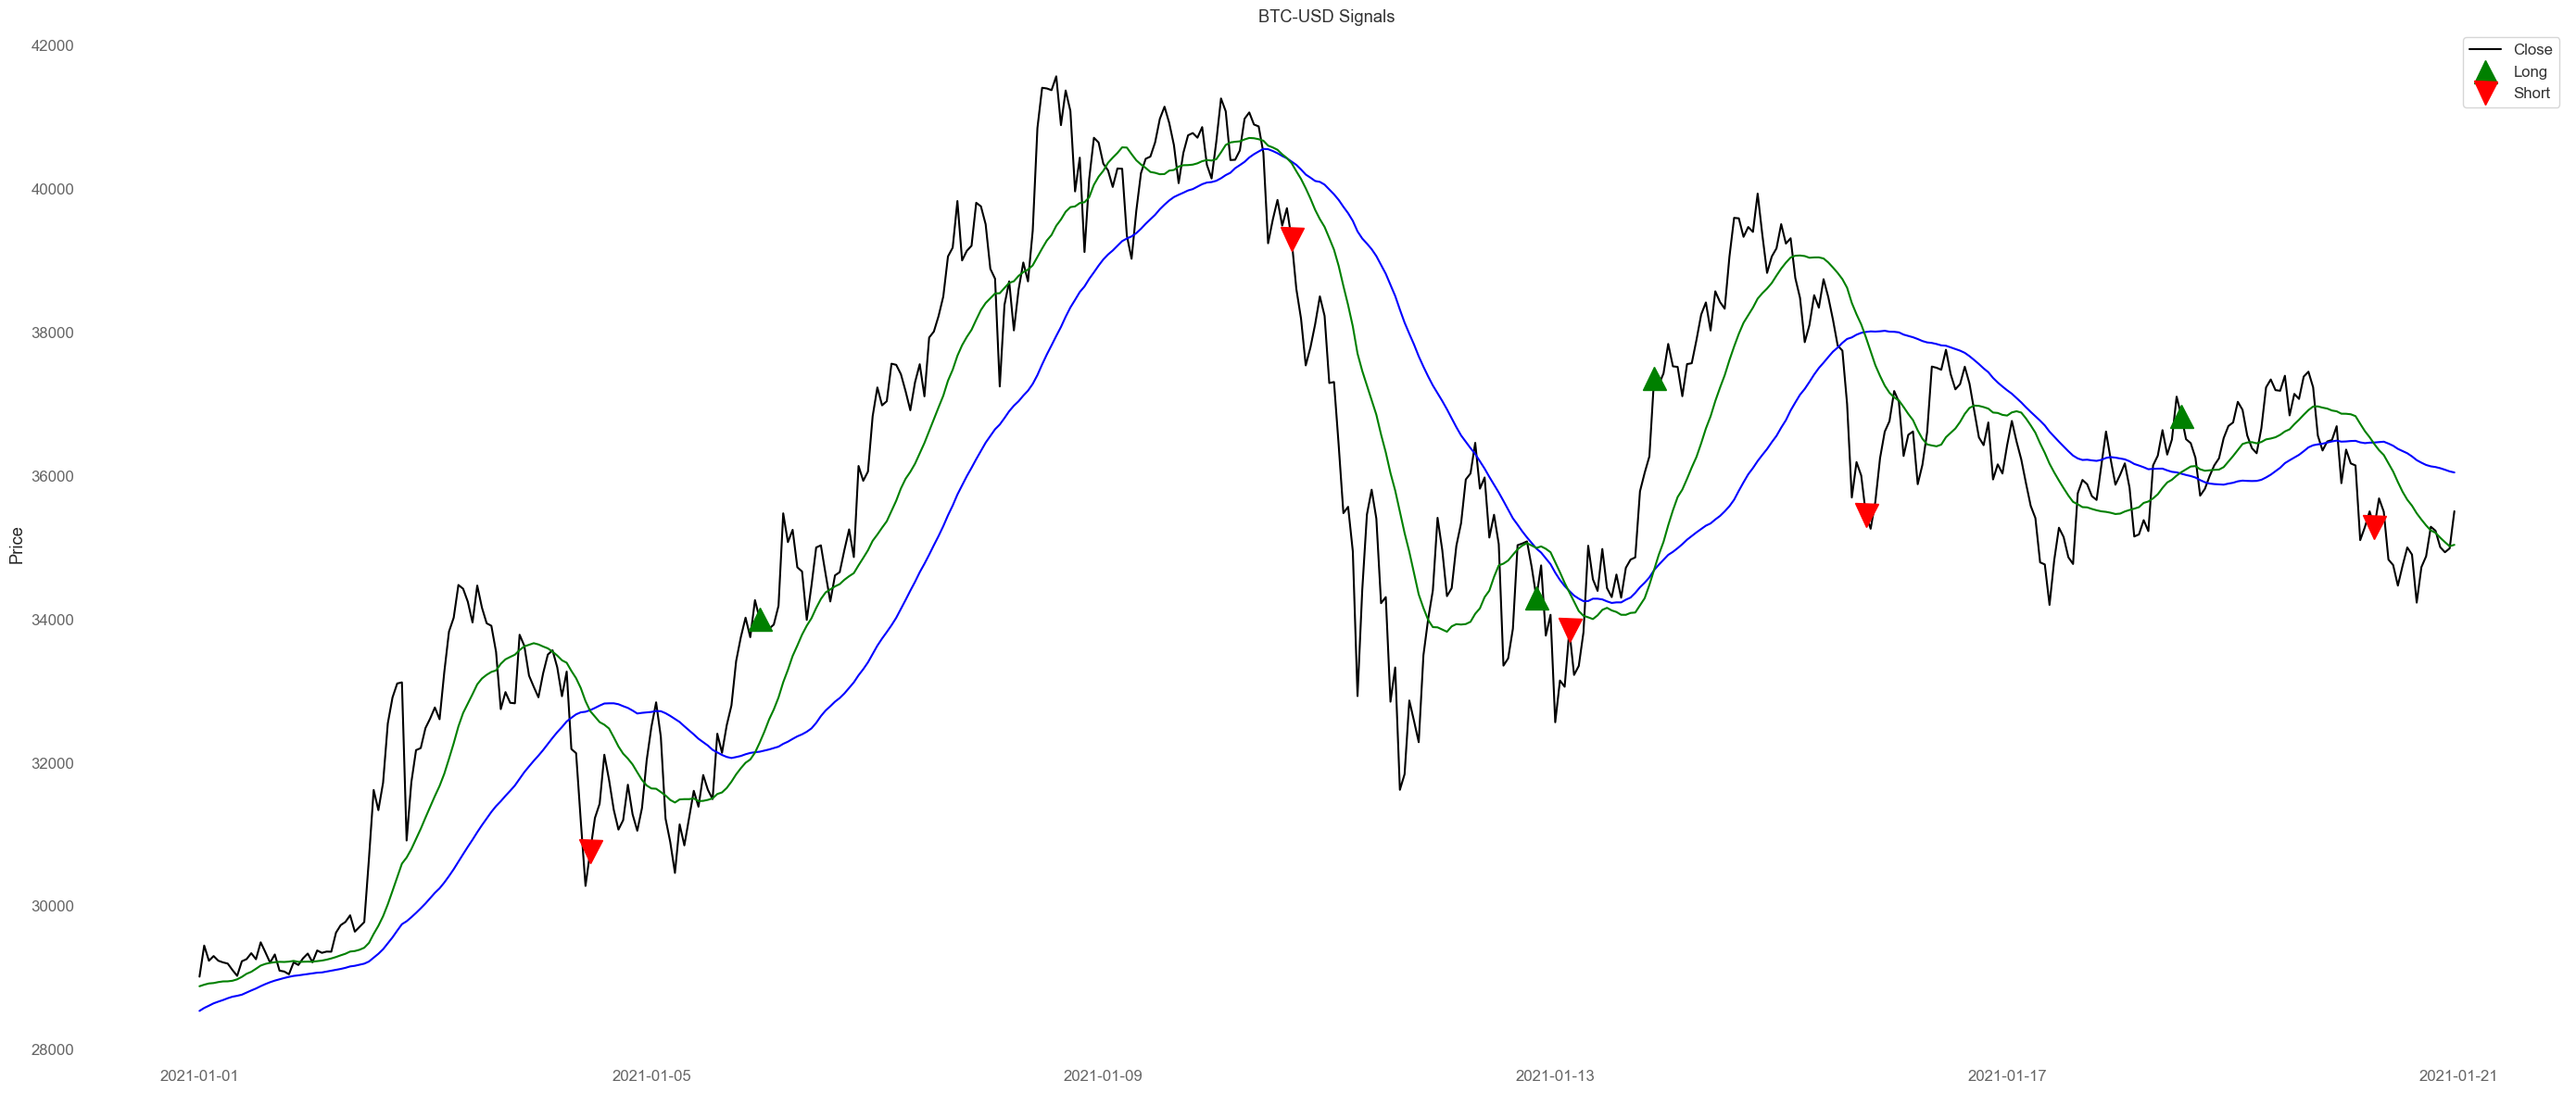

In [15]:
plot_df = df["2021-01-01":"2021-01-20"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=18, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=18, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [16]:
# Saving signals extracted on higher timeframe to lower granularity timeframe

df_eval = df_.copy(deep=True)

df_eval['Signal'] = 0

for idx, row in df[df['Signal']== 1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = 1

for idx, row in df[df['Signal']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = -1

look_ahead_shift = 1
df_eval['Signal' ] = df_eval['Signal' ].shift(hours*60+look_ahead_shift)

df_eval.dropna(inplace=True)

In [17]:
df_eval['Signal'].value_counts()

Signal
 0.0    2097166
 1.0        427
-1.0        426
Name: count, dtype: int64

In [18]:
# Position tracking

position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df_eval.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close']
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))

        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close']

        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close']

        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [19]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.05    # 0.05% commission fee per trade
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [20]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2020-01-03 17:01:00,2020-01-03 17:02:00,7399.86,7377.66,-0.300006,-0.300006,-60.101135,9939.898865,NaN
2020-01-09 08:01:00,2020-01-09 08:02:00,7945.37,7955.47,0.127118,-0.172888,25.171414,9965.070279,0.002532
2020-01-11 00:01:00,2020-01-11 00:02:00,8187.27,8176.79,-0.128004,-0.300891,-25.610947,9939.459331,-0.002570
2020-01-12 19:01:00,2020-01-12 19:02:00,8124.07,8124.07,0.000000,-0.300891,-0.099395,9939.359937,-0.000010
2020-01-12 20:01:00,2020-01-12 20:02:00,8138.58,8144.99,0.078761,-0.222131,15.557219,9954.917156,0.001565
...,...,...,...,...,...,...,...,...
2023-12-26 04:01:00,2023-12-26 04:02:00,43483.10,43473.10,-0.022997,2.569409,-4.895819,10412.875584,-0.000470
2023-12-26 09:01:00,2023-12-26 09:02:00,42719.90,42746.80,0.062968,2.632377,13.009495,10425.885079,0.001249
2023-12-27 22:01:00,2023-12-27 22:02:00,43419.00,43387.10,-0.073470,2.558907,-15.424084,10410.460996,-0.001479


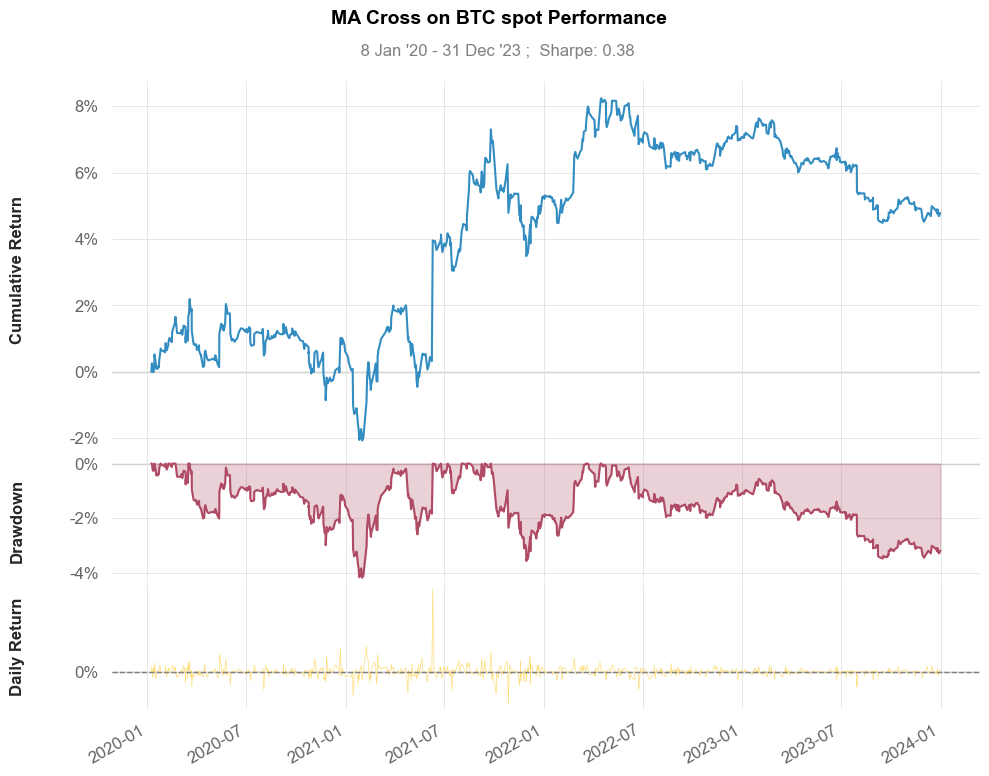

In [21]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC spot Performance', show=True);

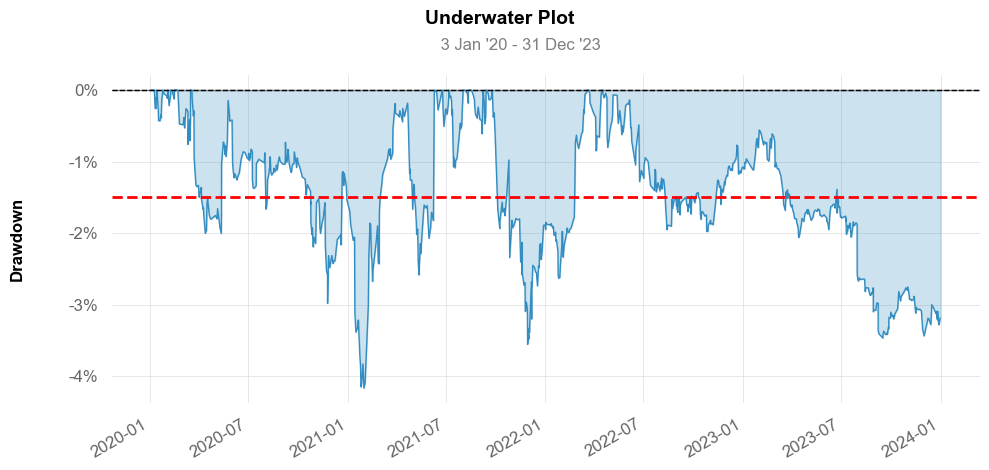

In [22]:
qs.plots.drawdown(position_df['Account Change'])

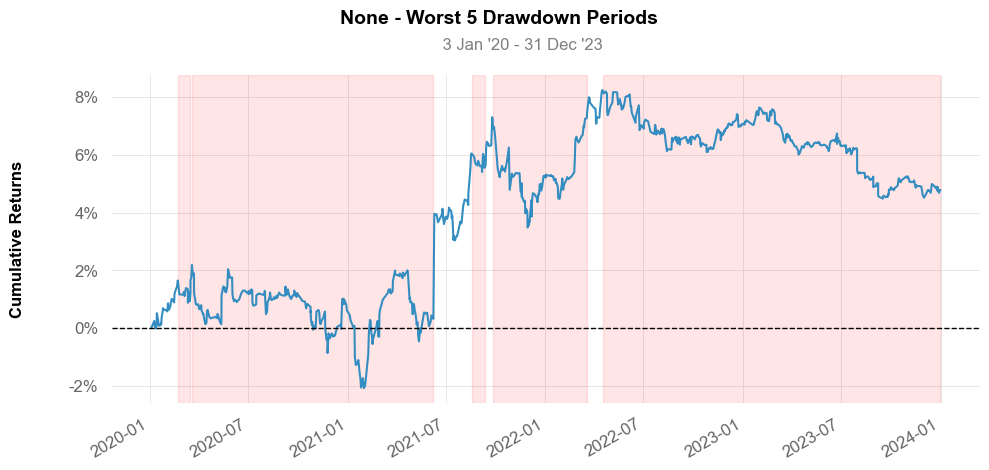

In [23]:
qs.plots.drawdowns_periods(position_df['Account Change'])

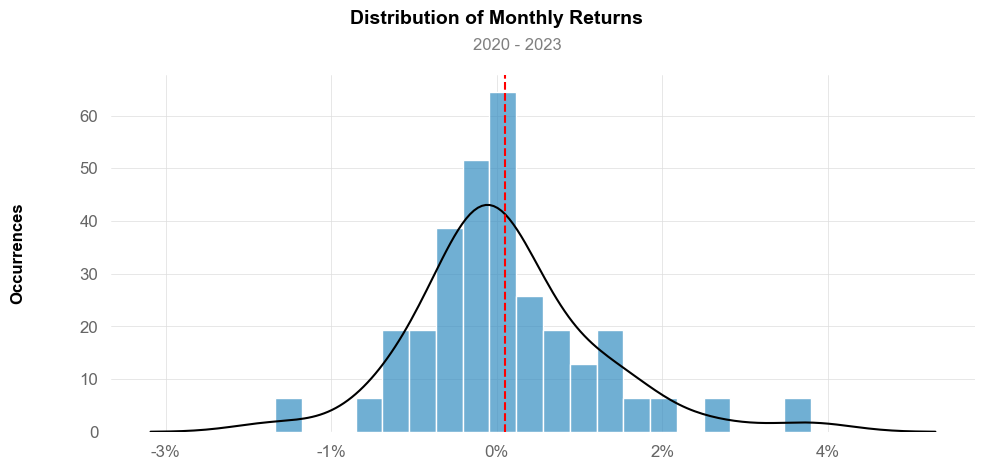

In [24]:
qs.plots.histogram(position_df['Account Change'])

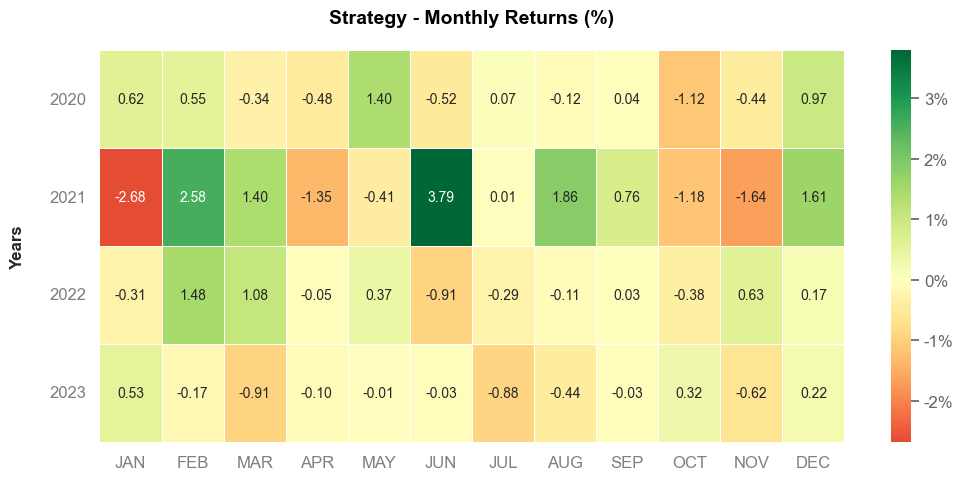

In [25]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [26]:
qs.stats.sharpe(position_df['Account Change'])

0.3826102210432692

<Axes: xlabel='Entry Time'>

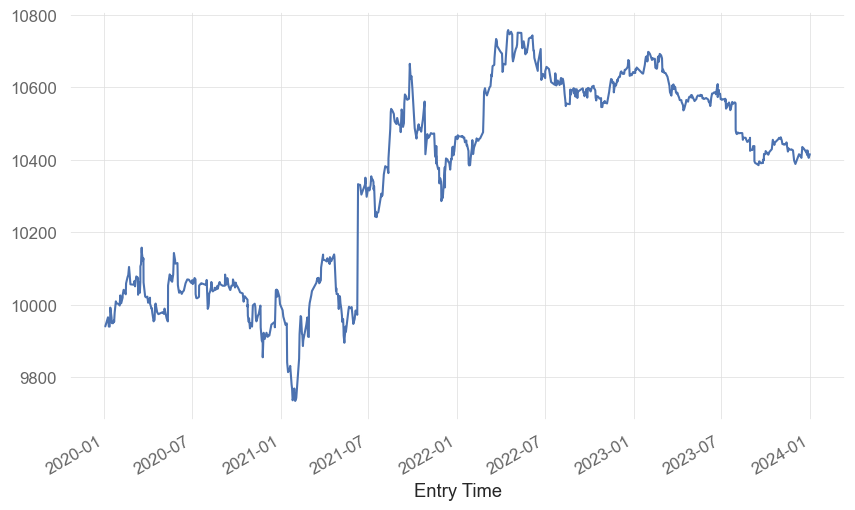

In [27]:
position_df["Account History"].plot()